In [53]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


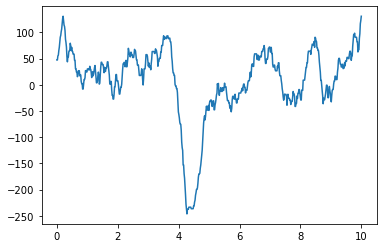

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [37]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [38]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
dm.mean_pooling_1d(size = 18, stride = 16, padding = 0)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 39)
X_test: shape of(2649, 35, 39)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


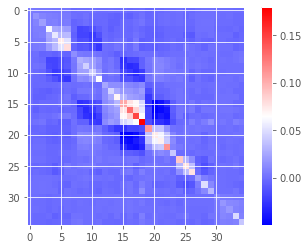

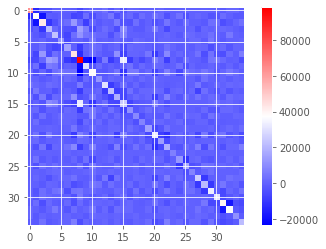

In [39]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

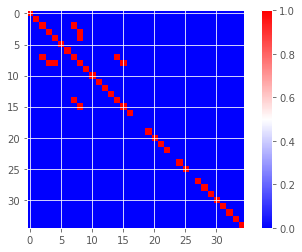

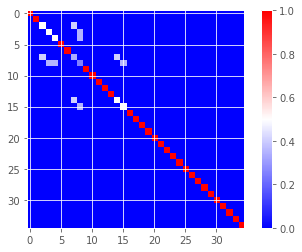

In [40]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

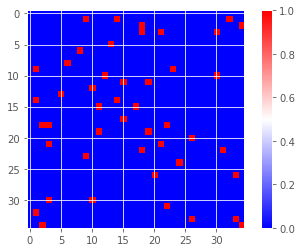

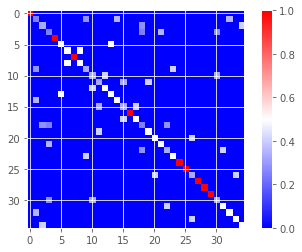

In [48]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

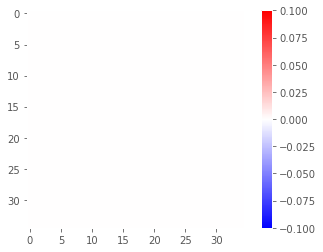

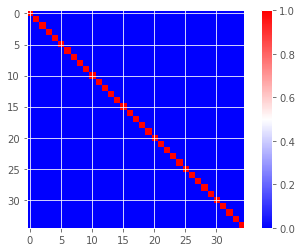

In [59]:
n = 1000.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  A3#dm.A_train

In [55]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,78], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 78], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

In [56]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, Araw)

 27%|██▋       | 3/11 [00:00<00:00, 27.35it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 4 of size 256   Train loss: 222.52682495117188   Valid loss: 216.69149780273438

100%|██████████| 11/11 [00:00<00:00, 30.64it/s]

Epoch: 1   Batch: 11 of size 256   Train loss: 213.27496337890625   Valid loss: 219.68609619140625
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


 14%|█▍        | 3/21 [00:00<00:00, 19.92it/s]

 29%|██▊       | 6/21 [00:00<00:00, 20.20it/s]

 57%|█████▋    | 12/21 [00:00<00:00, 21.29it/s]

Epoch: 1   Batch: 12 of size 128   Train loss: 243.1512451171875   Valid loss: 241.4580078125797

 71%|███████▏  | 15/21 [00:00<00:00, 21.58it/s]

Epoch: 1   Batch: 16 of size 128   Train loss: 236.26950073242188   Valid loss: 235.24879455566406

100%|██████████| 21/21 [00:00<00:00, 22.26it/s]

Epoch: 1   Batch: 21 of size 128   Train loss: 228.0296630859375   Valid loss: 227.195007324218758
----------Training Ends-----------


----------Training MLP-----------
0.674 ----------saved-----------
0.764 ----------saved-----------
0.803

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


 ----------saved-----------
0.818 ----------saved-----------
0.827 ----------saved-----------
0.832 ----------saved-----------
0.843 ----------saved-----------
0.849 ----------saved-----------
0.854 ----------saved-----------
0.861 ----------saved-----------
0.867 ----------saved-----------
0.87 ----------saved-----------
0.875 ----------saved-----------
0.879 ----------saved-----------
0.882 ----------saved-----------
0.887 ----------saved-----------
0.891 ----------saved-----------
0.894 ----------saved-----------
0.897 ----------saved-----------
0.898 ----------saved-----------
0.9 ----------saved-----------
0.901 ----------saved-----------
0.901 ----------saved-----------
0.902 ----------saved-----------
0.903 ----------saved-----------
0.903 ----------saved-----------
0.904 ----------saved-----------


C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.905 ----------saved-----------
0.725 ----------saved-----------
0.782 ----------saved-----------
0.821 ----------saved-----------
0.848 ----------saved-----------
0.857 ----------saved-----------
0.861 ----------saved-----------
0.867 ----------saved-----------
0.871 ----------saved-----------
0.881 ----------saved-----------
0.887 ----------saved-----------
0.889 ----------saved-----------
0.892 ----------saved-----------
0.896 ----------saved-----------
0.899 ----------saved-----------
0.902 ----------saved-----------
0.905 ----------saved-----------
0.908 ----------saved-----------
0.911 ----------saved-----------
0.913 ----------saved-----------
0.914 ----------saved-----------
0.916 ----------saved-----------
0.918 ----------saved-----------
0.919 ----------saved-----------
0.92 ----------saved-----------
0.921 ----------saved-----------
0.922 ----------saved-----------
0.923 ----------saved-----------
0.924 ----------saved-----------
0.924 ----------saved-----------
0.924 -----

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.1809 F1 accuracy 0.579 Precision accuracy 0.44 Recall accuracy 0.847 AUC accuracy: 0.921
device set to cuda
threshold: 0.1  validation loss: 0.1809 F1 accuracy 0.66 Precision accuracy 0.576 Recall accuracy 0.773 AUC accuracy: 0.921
device set to cuda
threshold: 0.15  validation loss: 0.1809 F1 accuracy 0.684 Precision accuracy 0.644 Recall accuracy 0.729 AUC accuracy: 0.921
device set to cuda
threshold: 0.2  validation loss: 0.1809 F1 accuracy 0.693 Precision accuracy 0.709 Recall accuracy 0.678 AUC accuracy: 0.921
device set to cuda
threshold: 0.25  validation loss: 0.1809 F1 accuracy 0.697 Precision accuracy 0.75 Recall accuracy 0.651 AUC accuracy: 0.921
device set to cuda
threshold: 0.3  validation loss: 0.1809 F1 accuracy 0.705 Precision accuracy 0.798 Recall accuracy 0.631 AUC accuracy: 0.921
device set to cuda
threshold: 0.35  validation loss: 0.1809 F1 accuracy 0.712 Precision accuracy 0.829 Recall accuracy 0.6

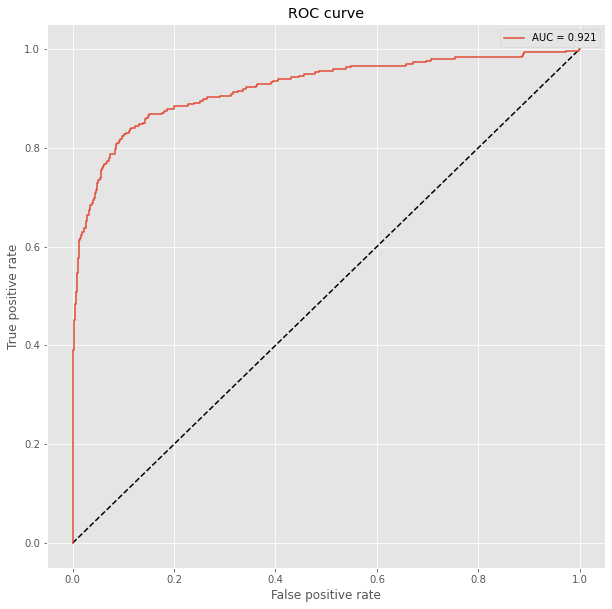

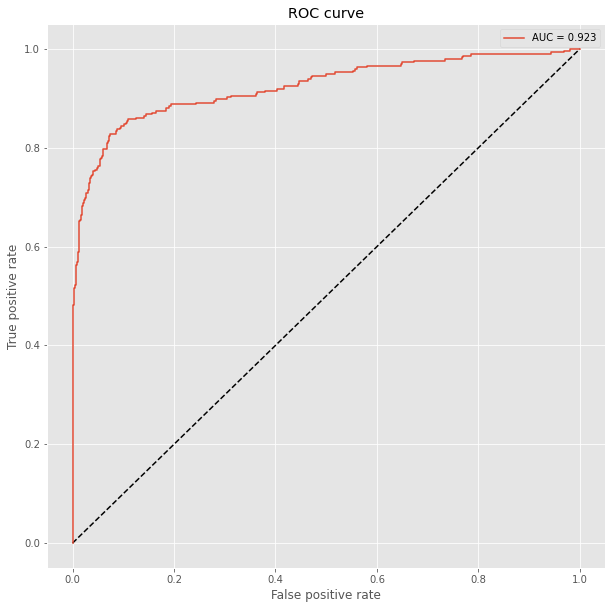

In [52]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')